<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/StarGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons
!pip install tensorflow-datasets --upgrade

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow_datasets as tfds
import os
import tempfile
import urllib

import warnings
warnings.filterwarnings('ignore')

In [3]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_HEIGHT = IMG_WIDTH = 256

gcs_base_dir = "gs://celeb_a_dataset/"
celeb_a_builder = tfds.builder("celeb_a", data_dir=gcs_base_dir, version='2.0.0')

celeb_a_builder.download_and_prepare()

num_test_shards_dict = {'0.3.0': 4, '2.0.0': 2} # Used because we download the test dataset separately
version = str(celeb_a_builder.info.version)
print('Celeb_A dataset version: %s' % version)

local_root = tempfile.mkdtemp(prefix='test-data')
def local_test_filename_base():
  return local_root

def local_test_file_full_prefix():
  return os.path.join(local_test_filename_base(), "celeb_a-test.tfrecord")

def copy_test_files_to_local():
  filename_base = local_test_file_full_prefix()
  num_test_shards = num_test_shards_dict[version]
  for shard in range(num_test_shards):
    url = "https://storage.googleapis.com/celeb_a_dataset/celeb_a/%s/celeb_a-test.tfrecord-0000%s-of-0000%s" % (version, shard, num_test_shards)
    filename = "%s-0000%s-of-0000%s" % (filename_base, shard, num_test_shards)
    res = urllib.request.urlretrieve(url, filename)

train, test = celeb_a_builder.as_dataset(split=['train', 'test'])
# Copy test data locally to be able to read it into tfma
copy_test_files_to_local()

def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, tf.float32) / 127.5 - 1

    #Use for only 2 possible domains, you can try as many as you like
    attributes = sample['attributes']
    young_attr = attributes['Young']
    young = tf.squeeze(tf.where(young_attr,
                                [tf.ones([IMG_WIDTH, IMG_HEIGHT, 1],
                                         dtype=tf.float32)],
                                 [tf.zeros([IMG_WIDTH, IMG_HEIGHT, 1],
                                           dtype=tf.float32)]), axis=0)

    not_young = tf.squeeze(tf.where(young_attr,
                                [tf.zeros([IMG_WIDTH, IMG_HEIGHT, 1],
                                           dtype=tf.float32)],
                                [tf.ones([IMG_WIDTH, IMG_HEIGHT, 1],
                                         dtype=tf.float32)]), axis=0)
    
    return image, young, not_young


train = train.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test = test.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1).repeat()

Celeb_A dataset version: 2.0.0


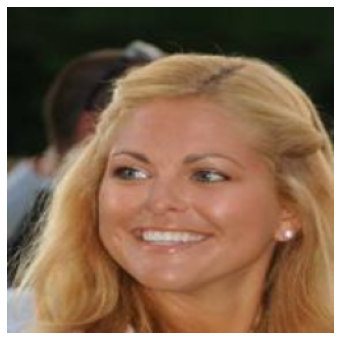

In [4]:
img,  _, _= next(iter(test.take(1)))

figure = plt.figure(figsize=(8,6))
plt.imshow((img[0] + 1) / 2.)
plt.axis('off')
plt.show()

In [5]:
def downsample(channels, kernels, strides=2, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                            use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

def upsample(channels, kernels, strides=1, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.UpSampling2D((2,2)))
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

In [6]:
def build_generator():

    DIM = 64

    input_image = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    input_class = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

    concat = layers.Concatenate()([input_image, input_class])
    down1 = downsample(DIM, 4, norm=False)(concat) # 128, DIM
    down2 = downsample(2*DIM, 4)(down1) # 64, 2*DIM
    down3 = downsample(4*DIM, 4)(down2) # 32, 4*DIM
    down4 = downsample(4*DIM, 4)(down3) # 16, 4*DIM
    down5 = downsample(4*DIM, 4)(down4) # 8, 4*DIM
    down6 = downsample(4*DIM, 4)(down5) # 4, 4*DIM
    down7 = downsample(4*DIM, 4)(down6) # 2, 4*DIM


    up6 = upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
    concat6 = layers.Concatenate()([up6, down6])   

    up5 = upsample(4*DIM, 4, dropout=True)(concat6) 
    concat5 = layers.Concatenate()([up5, down5]) 

    up4 = upsample(4*DIM, 4, dropout=True)(concat5) 
    concat4 = layers.Concatenate()([up4, down4]) 

    up3 = upsample(4*DIM, 4)(concat4) 
    concat3 = layers.Concatenate()([up3, down3]) 

    up2 = upsample(2*DIM, 4)(concat3) 
    concat2 = layers.Concatenate()([up2, down2]) 

    up1 = upsample(DIM, 4)(concat2) 
    concat1 = layers.Concatenate()([up1, down1]) 

    output_image = tf.keras.activations.tanh(upsample(3, 4, norm=False, activation=False)(concat1))

    return Model([input_image, input_class], output_image)

In [7]:
def build_discriminator():
    DIM = 64
    input_image = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    features = downsample(DIM, 4, norm=False)(input_image) # 128

    x = downsample(2*DIM, 4)(features) # 64
    x = downsample(4*DIM, 4)(x) # 32
    x = downsample(8*DIM, 4, strides=1)(x) # 29

    real = layers.Flatten()(x)
    real = layers.Dense(128)(real)
    real = layers.LeakyReLU(0.2)(real)
    real = layers.Dense(1, activation='sigmoid')(real)
    y = layers.Flatten()(features)
    y = layers.Dense(128)(y)
    y = layers.LeakyReLU(0.2)(y)
    label = layers.Dense(1, activation='sigmoid')(y)

    return Model(input_image, [real, label])

In [8]:
class StarGAN(Model):

    def __init__(self):
        super(StarGAN, self).__init__()

        self.generator = build_generator()
        self.discriminator = build_discriminator()

        self.LAMBDA = 4
        self.LAMBDA_CLASS = 2
    
    def compile(self, recon_loss_fn = tf.keras.losses.mean_absolute_error,
                adv_loss_fn=tf.keras.losses.binary_crossentropy):
        
        super(StarGAN, self).compile()

        self.d_optimizer = Adam(1e-4)
        self.g_optimizer = Adam(1e-4)
        self.recon_loss_fn = recon_loss_fn
        self.adv_loss_fn = adv_loss_fn
    
    def train_step(self, inputs):
        real_images, real_labels, opp_labels = inputs

        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as d_tape, \
            tf.GradientTape() as g_tape:

            opp_images = self.generator([real_images, opp_labels])

            fake_preds, fake_pred_labels = self.discriminator(opp_images)
            real_preds, real_pred_labels = self.discriminator(real_images)

            cycle_images = self.generator([opp_images, real_labels])

            fake_loss = self.adv_loss_fn(tf.zeros([batch_size, 1]), fake_preds)
            real_loss = self.adv_loss_fn(tf.ones([batch_size, 1]), real_preds)
            d_adv_loss = 0.5 * (fake_loss + real_loss)

            real_pred_labels = tf.tile(tf.reshape(real_pred_labels, (batch_size, 1, 1, 1)), [1, 256, 256, 1])
            fake_pred_labels = tf.tile(tf.reshape(fake_pred_labels, (batch_size, 1, 1, 1)), [1, 256, 256, 1])

            d_class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_pred_labels))
            g_class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(opp_labels, fake_pred_labels))

            g_adv_loss = tf.reduce_mean(self.adv_loss_fn(tf.ones([batch_size, 1]), fake_preds))

            g_cycle_cons_loss = self.recon_loss_fn(real_images, cycle_images) 

            d_loss = (d_adv_loss + self.LAMBDA_CLASS * d_class_loss) / (1 + self.LAMBDA_CLASS)
            g_loss = (self.LAMBDA * g_cycle_cons_loss + self.LAMBDA_CLASS * g_class_loss + g_adv_loss) / (self.LAMBDA + self.LAMBDA_CLASS + 1)

        g_vars = self.generator.trainable_variables
        d_vars = self.discriminator.trainable_variables

        g_grads = g_tape.gradient(g_loss, g_vars)
        d_grads = d_tape.gradient(d_loss, d_vars)

        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))
        self.d_optimizer.apply_gradients(zip(d_grads, d_vars))

        return {'g_loss': g_loss, 'd_loss': d_loss}
    
    def call(self, inputs):
        image, domain = inputs
        return self.generator([image, domain])

In [9]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_dataset, num_imgs=2, interval=3):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval
        self.ds = iter(test_dataset)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 

        grid_row = 1
        grid_col = self.num_imgs

        img, domain, opp_domain = next(self.ds)
        generated = self.model(img, opp_domain)

        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        axarr[0].imshow((img[0] + 1)/2.)
        axarr[0].axis('off') 
        axarr[0].set_title(f'Original ({domain[0][0][0][0]})', fontsize=14)

        axarr[1].imshow((generated[0] + 1)/2.)
        axarr[1].axis('off') 
        axarr[1].set_title(f'Generated ({opp_domain[0][0][0][0]})', fontsize=14)
        
        plt.show()

In [ ]:
starGAN = StarGAN()

starGAN.compile()
callbacks = [GenerativeCallback(test, interval=1)]

starGAN.fit(train, epochs=5, callbacks=callbacks)

Epoch 1/5
    6/10173 [..............................] - ETA: 9:26:58 - g_loss: 4.2197 - d_loss: 3.6484WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 1.4525s vs `on_train_batch_end` time: 1.7196s). Check your callbacks.


  428/10173 [>.............................] - ETA: 9:09:16 - g_loss: 2.7481 - d_loss: 1.9558